# Matching, IPTW and Causal Forest

In [232]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx

from nxpd import draw

# Data generating process

$ \text{nerd} \sim \mathbb{B}(0.2) $  
$ \text{income} \sim \mathbb{B}(0.3) $  
$ \text{video_game} \sim \mathbb{B}(0.8) $  
$ \text{private_school} = \mathbb{B}(0.95) + \mathbb{B}(0.15) $  


$\text{grade} = 2 + \text{nerd} * (1 + \text{private_school}) + (1 - \text{video_games}) * \text{private_school} $

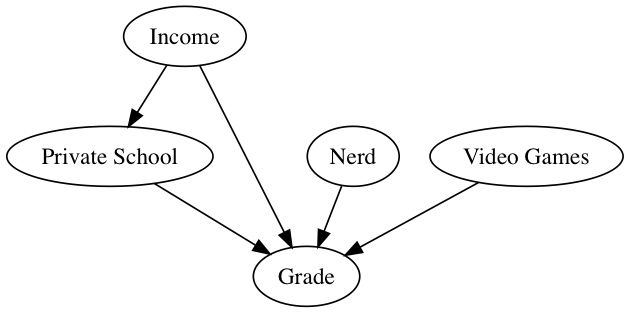

In [233]:
G = nx.DiGraph()
G.graph['dpi'] = 120

G.add_edges_from([("Private School", "Grade"), 
                  ("Income", "Grade"), 
                  ("Income", "Private School"),
                  ("Nerd", "Grade"), 
                  ("Video Games", "Grade")])

draw(G, show='ipynb')

TODO:
- Inverter a direção entre private school e income
- Inverter entre grade e private school

# Dataset

In [234]:
POPULATION = 10000

In [268]:
nerd = np.random.binomial(1, 0.2, size=POPULATION).flatten()
income = np.random.binomial(1, 0.3, size=POPULATION).flatten()
video_game = np.random.binomial(1, 0.8, size=POPULATION).flatten()

def private_school(income):
    return pd.DataFrame(income)[0].apply(lambda x : np.random.binomial(1, 0.95, 1)[0] if x == 1 else np.random.binomial(1, 0.15, 1)[0]).values
        
def grade(nerd, income, private_school, video_game):
            
    return 2 + np.random.normal(1, 0.05) * nerd + nerd * private_school +\
           (1 - video_game) * private_school +\
           2*income + np.random.normal(3, 0.05)*private_school 

In [269]:
data = pd.DataFrame()
data["nerd"] = nerd
data["income"] = income
data["video_game"] = video_game
data["private_school"] = private_school(data["income"].values)
data["grade"] = grade(data["nerd"], 
                      data["income"], 
                      data["private_school"],
                      data["video_game"])

In [270]:
data.head()

,nerd,income,video_game,private_school,grade
0,0,1,1,1,7.024479
1,1,0,1,0,3.053454
2,0,1,1,1,7.024479
3,0,0,1,0,2.000000
4,0,1,1,1,7.024479


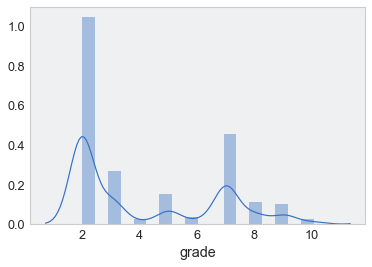

In [271]:
sns.distplot(data["grade"], label="Not treated")

### Truth


|   |Nerd: 0 |Nerd: 1 |
|---|---|---|
|Video Game: 0 | 1 + ~3  | 2 + ~3  |
|Video Game: 1 | ~3  | 1 + ~3  |


|   |Nerd: 0 |Nerd: 1 |
|---|---|---|
|Video Game: 0 | ~4 | ~5  |
|Video Game: 1 | ~3  | ~4  |

In [272]:
print("ATE: {}".format(3 + data["nerd"].mean() + (1 - data["video_game"].mean())))

ATE: 3.4022


In [273]:
print("ATE Nerds: {}".format(3 + 1 + (1 - data[data["nerd"] == 1]["video_game"].mean())))

ATE Nerds: 4.205607476635514


In [274]:
print("ATE Not Nerds: {}".format(3 + 0 + (1 - data[data["nerd"] == 0]["video_game"].mean())))

ATE Not Nerds: 3.1971884021589054


In [275]:
print("ATE Video Games: {}".format(3 + data[data["video_game"] == 1]["nerd"].mean()))

ATE Video Games: 3.2015978030208463


In [308]:
print("ATE Nerds + Video Games: {}".format(2 + 1].mean()))

ATE Nerds + Video Games: 3.2033


### RCT

In [277]:
def rct(data, n=10, frac=0.5):
    ate = []
    for i in range(n):
        experiment = data.sample(frac=frac).copy(deep=True)
        experiment["private_school"] = np.random.binomial(1, 0.5, size=len(experiment)).flatten()
        experiment["grade"] = grade(experiment["nerd"], 
                                    experiment["income"], 
                                    experiment["private_school"], 
                                    experiment["video_game"])
        
        ate.append(experiment[experiment["private_school"] == 1]["grade"].mean() - \
                   experiment[experiment["private_school"] == 0]["grade"].mean())
        
    print("ATE: [{}, {}]".format(np.mean(ate) - 2.57*np.std(ate), 
                                 np.mean(ate) + 2.57*np.std(ate)))

In [278]:
rct(data)

ATE: [3.245164025284784, 3.5106661412068165]


In [279]:
rct(data[data["nerd"] == 1])

ATE: [4.025305941593744, 4.402857048664299]


### Observational

In [280]:
def naive_observational(data, n=10, frac=0.8):
    ate = []
    for i in range(n):
        df = data.sample(frac=frac)
        ate.append(df[df["private_school"] == 1]["grade"].mean() - \
                   df[df["private_school"] == 0]["grade"].mean())

    print("ATE: [{}, {}]".format(np.mean(ate) - 2.57*np.std(ate), 
                                 np.mean(ate) + 2.57*np.std(ate)))

In [281]:
naive_observational(data)

ATE: [4.818136282642188, 4.874638471740774]


In [282]:
naive_observational(data[data["nerd"] == 1])

ATE: [5.5704038769606585, 5.672609838416032]


### Matching

In [283]:
def matching(data, n=3, frac=0.5):
    features = ["nerd",
                "video_game", 
                "income"]

    target = "grade"
    
    ate = []
    
    for i in range(n):
        print(i)
        sample_data = data.sample(frac=frac).copy(deep=True)

        minor_class = sample_data[sample_data["private_school"] == 1]
        major_class = sample_data[sample_data["private_school"] == 0]
        
        final_data = minor_class
        for k in range(len(minor_class)):
            x = major_class[(major_class[features] == minor_class.iloc[k][features]).apply(lambda x: all(x) , axis =1)].sample(1)
            final_data = pd.concat([final_data, x])       
            
            
        minor_class = final_data[final_data["private_school"] == 1]
        major_class = final_data[final_data["private_school"] == 0]

        ate.append(minor_class["grade"].mean() - major_class["grade"].mean())
        
    print("ATE: [{}, {}]".format(np.mean(ate) - 2.57*np.std(ate), 
                                 np.mean(ate) + 2.57*np.std(ate)))        

In [284]:
matching(data)

0
1
2
ATE: [3.4070188052744177, 3.4388482842621126]


### IPTW

In [285]:
def IPTW(data, n=3, frac=0.5):
    confounder = "income"
    target = "grade"
    treatment = "private_school"
    
    ate = []
    for i in range(n):
        sample_data = data.sample(frac=frac).copy(deep=True)
        
        pa1x1 = sample_data[sample_data[confounder] == 1][treatment].mean()
        pa0x1 = 1 - pa1x1
        
        pa1x0 = sample_data[sample_data[confounder] == 0][treatment].mean()
        pa0x0 = 1 - pa1x0
        
        sample_data["weight"] = 0
        sample_data.loc[(sample_data[treatment] == 1) & (sample_data[confounder] == 1), "weight"] = 1.0/pa1x1
        sample_data.loc[(sample_data[treatment] == 1) & (sample_data[confounder] == 0), "weight"] = 1.0/pa1x0
        sample_data.loc[(sample_data[treatment] == 0) & (sample_data[confounder] == 1), "weight"] = 1.0/pa0x1
        sample_data.loc[(sample_data[treatment] == 0) & (sample_data[confounder] == 0), "weight"] = 1.0/pa0x0
        
        Ey1 = (sample_data[sample_data[treatment] == 1][target] *\
              sample_data[sample_data[treatment] == 1]["weight"]).sum() /\
              (sample_data[sample_data[treatment] == 1]["weight"]).sum()
        
        Ey0 = (sample_data[sample_data[treatment] == 0][target] *\
              sample_data[sample_data[treatment] == 0]["weight"]).sum() /\
              (sample_data[sample_data[treatment] == 0]["weight"]).sum()
        
        ate.append(Ey1 - Ey0)
                
    print("ATE: [{}, {}]".format(np.mean(ate) - 2.57*np.std(ate), 
                                 np.mean(ate) + 2.57*np.std(ate)))        

In [286]:
IPTW(data, n=10)

ATE: [3.390105875562717, 3.50811586411553]


In [287]:
IPTW(data[data["nerd"] == 1])

ATE: [4.203134490919442, 4.244973759733691]


In [288]:
IPTW(data[data["nerd"] == 0])

ATE: [3.1963664181470137, 3.271916328891566]


In [289]:
IPTW(data[data["video_game"] == 1])

ATE: [3.172008559607003, 3.2963370436321147]


In [290]:
IPTW(data[data["video_game"] == 0])

ATE: [4.210498738241606, 4.25704437232115]


In [291]:
IPTW(data[(data["video_game"] == 0) & (data["nerd"] == 0)])

ATE: [4.024479474317234, 4.024479474317239]


In [292]:
IPTW(data[(data["video_game"] == 0) & (data["nerd"] == 1)])

ATE: [5.024479474317232, 5.024479474317241]


In [293]:
IPTW(data[(data["video_game"] == 1) & (data["nerd"] == 0)])

ATE: [3.0244794743172347, 3.024479474317239]


In [294]:
IPTW(data[(data["video_game"] == 1) & (data["nerd"] == 1)])

ATE: [4.0244794743172365, 4.024479474317238]


### Causal Forest

In [317]:
from sklearn.model_selection import train_test_split

features = ["nerd",
            "video_game", 
            "income",
            "private_school"]

target = "grade"

X_train, X_test = train_test_split(data, 
                                   test_size=0.2,
                                   random_state=42)

**R...**

In [318]:
X_train.to_csv("train.csv")
X_test.to_csv("test.csv")

```
> average_treatment_effect(tau.forest, target.sample = "all")
  estimate    std.err 
3.39736856 0.00272897 
```

In [319]:
prediction = pd.read_csv("causal_forest_predictions.csv")

In [320]:
X_test.loc[:, "predictions"] = prediction["predictions"].values

|   |Nerd: 0 |Nerd: 1 |
|---|---|---|
|Video Game: 0 | ~4 | ~5  |
|Video Game: 1 | ~3  | ~4  |

In [322]:
X_test[(X_test["nerd"] == 0) & (X_test["video_game"] == 0)].head()

,nerd,income,video_game,private_school,grade,predictions
6252,0,0,0,0,2.000000,3.998753
4521,0,1,0,1,8.024479,4.022188
439,0,0,0,0,2.000000,3.998753
2750,0,0,0,0,2.000000,3.998753
9930,0,0,0,0,2.000000,3.998753


In [323]:
X_test[(X_test["nerd"] == 0) & (X_test["video_game"] == 1)].head()

,nerd,income,video_game,private_school,grade,predictions
4684,0,1,1,1,7.024479,3.072552
1731,0,0,1,0,2.000000,3.043072
4742,0,0,1,0,2.000000,3.043072
6340,0,0,1,1,5.024479,3.043072
576,0,0,1,0,2.000000,3.043072


In [324]:
X_test[(X_test["nerd"] == 1) & (X_test["video_game"] == 0)].head()

,nerd,income,video_game,private_school,grade,predictions
5653,1,0,0,0,3.053454,4.948334
3032,1,0,0,0,3.053454,4.948334
2753,1,0,0,0,3.053454,4.948334
7942,1,1,0,1,10.077933,4.900574
5527,1,0,0,0,3.053454,4.948334


In [325]:
X_test[(X_test["nerd"] == 1) & (X_test["video_game"] == 1)].head()

,nerd,income,video_game,private_school,grade,predictions
7487,1,0,1,1,7.077933,4.008196
582,1,0,1,0,3.053454,4.008196
9920,1,0,1,0,3.053454,4.008196
321,1,0,1,0,3.053454,4.008196
251,1,0,1,0,3.053454,4.008196


### RCT x Observational plots

In [17]:
a = np.random.normal(1, 0.5, 10 ** 5)
a2 = np.random.normal(1, 0.5, 10 ** 5)
b = np.random.normal(1.5, 0.7, 10 ** 5)

Text(0.5,1,'Feature distribution for RCT')

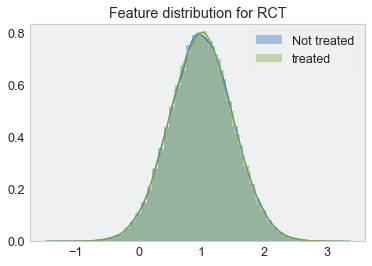

In [18]:
sns.distplot(a, label="Not treated")
sns.distplot(a2, label="treated")
plt.legend()
plt.title("Feature distribution for RCT")

Text(0.5,1,'Feature distribution for treated and not treated')

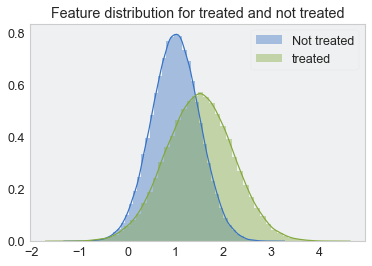

In [15]:
sns.distplot(a, label="Not treated")
sns.distplot(b, label="treated")
plt.legend()
plt.title("Feature distribution for treated and not treated")